In [78]:
import string
from typing import NamedTuple, Tuple, List, Dict


import pandas as pd
import numpy as np
from toolz import pipe

from nlpretext import Preprocessor
from nlpretext.basic.preprocess import (
    normalize_whitespace,
    remove_punct,
    remove_eol_characters,
    remove_stopwords,
    lower_text,
    unpack_english_contractions,
)
from nlpretext.social.preprocess import remove_mentions, remove_hashtag, remove_emoji
from wordcloud import STOPWORDS

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    classification_report,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
)
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from tqdm import tqdm
from wordcloud import WordCloud
import xgboost
import matplotlib.pyplot as plt

import torch
from transformers import (
    pipeline,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
)
import seaborn as sns

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data & EDA (EDA Copied from https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert)

In [109]:
train_df = pd.read_csv("../nlp-getting-started/train.csv")
test_df = pd.read_csv("../nlp-getting-started/test.csv")

In [110]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


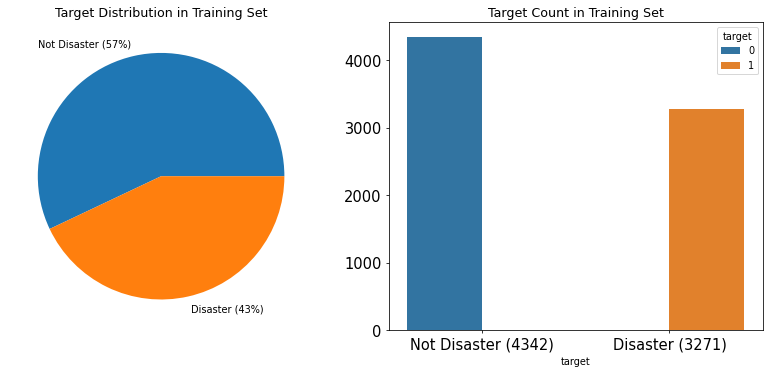

In [111]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), dpi=70)
plt.tight_layout()

train_df.groupby("target").count()["id"].plot(
    kind="pie", ax=axes[0], labels=["Not Disaster (57%)", "Disaster (43%)"]
)
sns.countplot(x=train_df["target"], hue=train_df["target"], ax=axes[1])

axes[0].set_ylabel("")
axes[1].set_ylabel("")
axes[1].set_xticklabels(["Not Disaster (4342)", "Disaster (3271)"])
axes[0].tick_params(axis="x", labelsize=15)
axes[0].tick_params(axis="y", labelsize=15)
axes[1].tick_params(axis="x", labelsize=15)
axes[1].tick_params(axis="y", labelsize=15)

axes[0].set_title("Target Distribution in Training Set", fontsize=13)
axes[1].set_title("Target Count in Training Set", fontsize=13)

plt.show()

## Insights

- Target distribution is almost similar so the dataset doesn't require any upsampling/downsampling treatment for class balance. Also, it doesn't require any stratification in cross-validation.

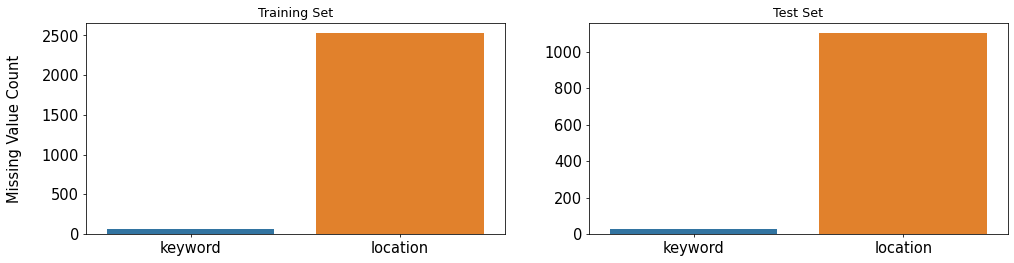

In [112]:
missing_cols = ["keyword", "location"]

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=70)

sns.barplot(
    x=train_df[missing_cols].isnull().sum().index,
    y=train_df[missing_cols].isnull().sum().values,
    ax=axes[0],
)
sns.barplot(
    x=test_df[missing_cols].isnull().sum().index,
    y=test_df[missing_cols].isnull().sum().values,
    ax=axes[1],
)

axes[0].set_ylabel("Missing Value Count", size=15, labelpad=20)
axes[0].tick_params(axis="x", labelsize=15)
axes[0].tick_params(axis="y", labelsize=15)
axes[1].tick_params(axis="x", labelsize=15)
axes[1].tick_params(axis="y", labelsize=15)

axes[0].set_title("Training Set", fontsize=13)
axes[1].set_title("Test Set", fontsize=13)

plt.show()

for df in [train_df, test_df]:
    for col in ["keyword", "location"]:
        df[col] = df[col].fillna(f"no_{col}")

## Insights

- 0.8% of keyword is missing in both training and test set.
- 33% of location is missing in both training and test set. It could be because it is not automatically generated and provided by user. Also, it has many unique values in it so it shouldn't be used as feature.
- Missing value ratios are almost similar in train & test data which indicates that train and test datasets came from same distribution.

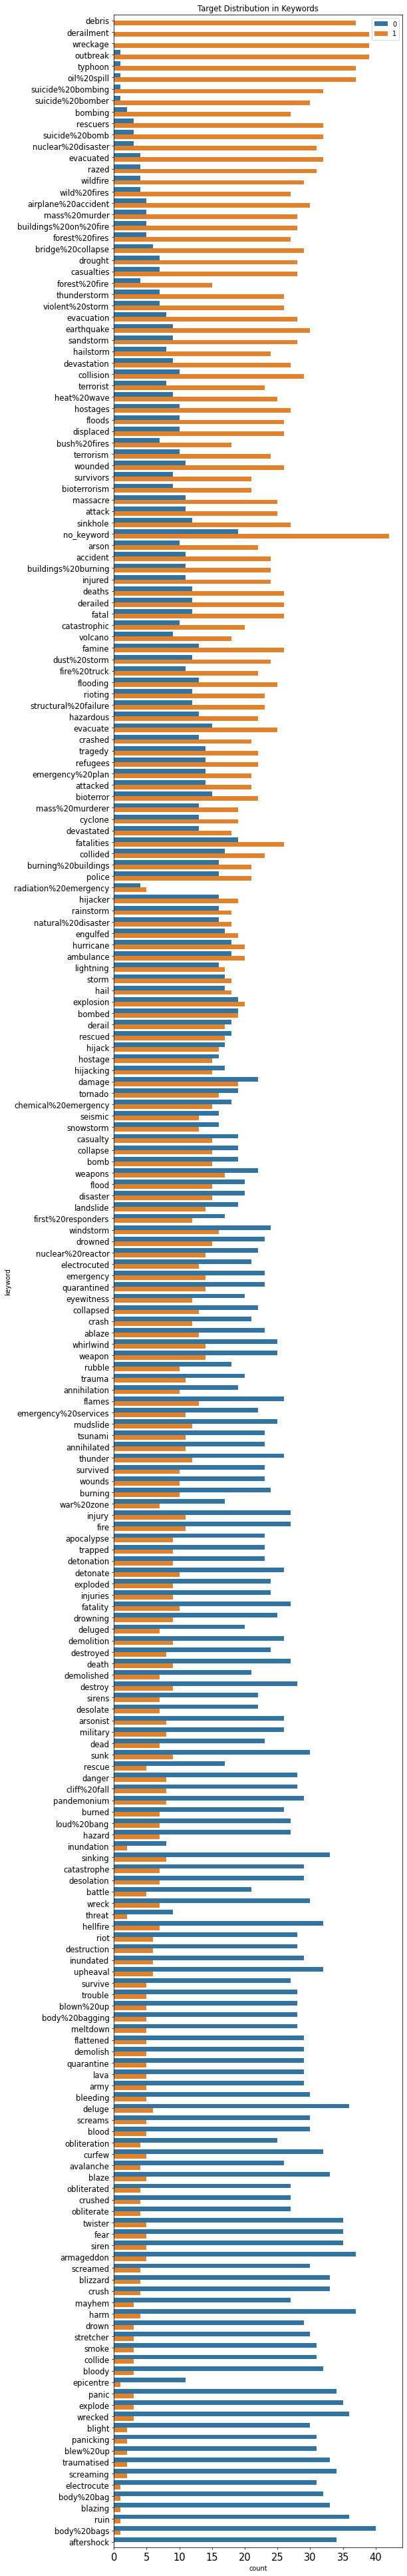

In [113]:
train_df["target_mean"] = train_df.groupby("keyword")["target"].transform("mean")

fig = plt.figure(figsize=(8, 72), dpi=70)

sns.countplot(
    y=train_df.sort_values(by="target_mean", ascending=False)["keyword"],
    hue=train_df.sort_values(by="target_mean", ascending=False)["target"],
)

plt.tick_params(axis="x", labelsize=15)
plt.tick_params(axis="y", labelsize=12)
plt.legend(loc=1)
plt.title("Target Distribution in Keywords")

plt.show()

train_df.drop(columns=["target_mean"], inplace=True)

### Insights

- `keywords` has some signal inside it and can be used as feature. Not using it for now and will leave it as future improvement.

# Meta Features (taken from https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert)

Distributions of meta features in classes and datasets can be helpful to identify disaster tweets. It looks like disaster tweets are written in a more formal way with longer words compared to non-disaster tweets because most of them are coming from news agencies. Non-disaster tweets have more typos than disaster tweets because they are coming from individual users. The meta features used for the analysis are;

- `word_count number` of words in text
- `unique_word_count` number of unique words in text
- `stop_word_count number` of stop words in text
- `url_count` number of urls in text
- `mean_word_length` average character count in words
- `char_count number` of characters in text
- `punctuation_count` number of punctuations in text
- `hashtag_count` number of hashtags (#) in text
- `mention_count` number of mentions (@) in text

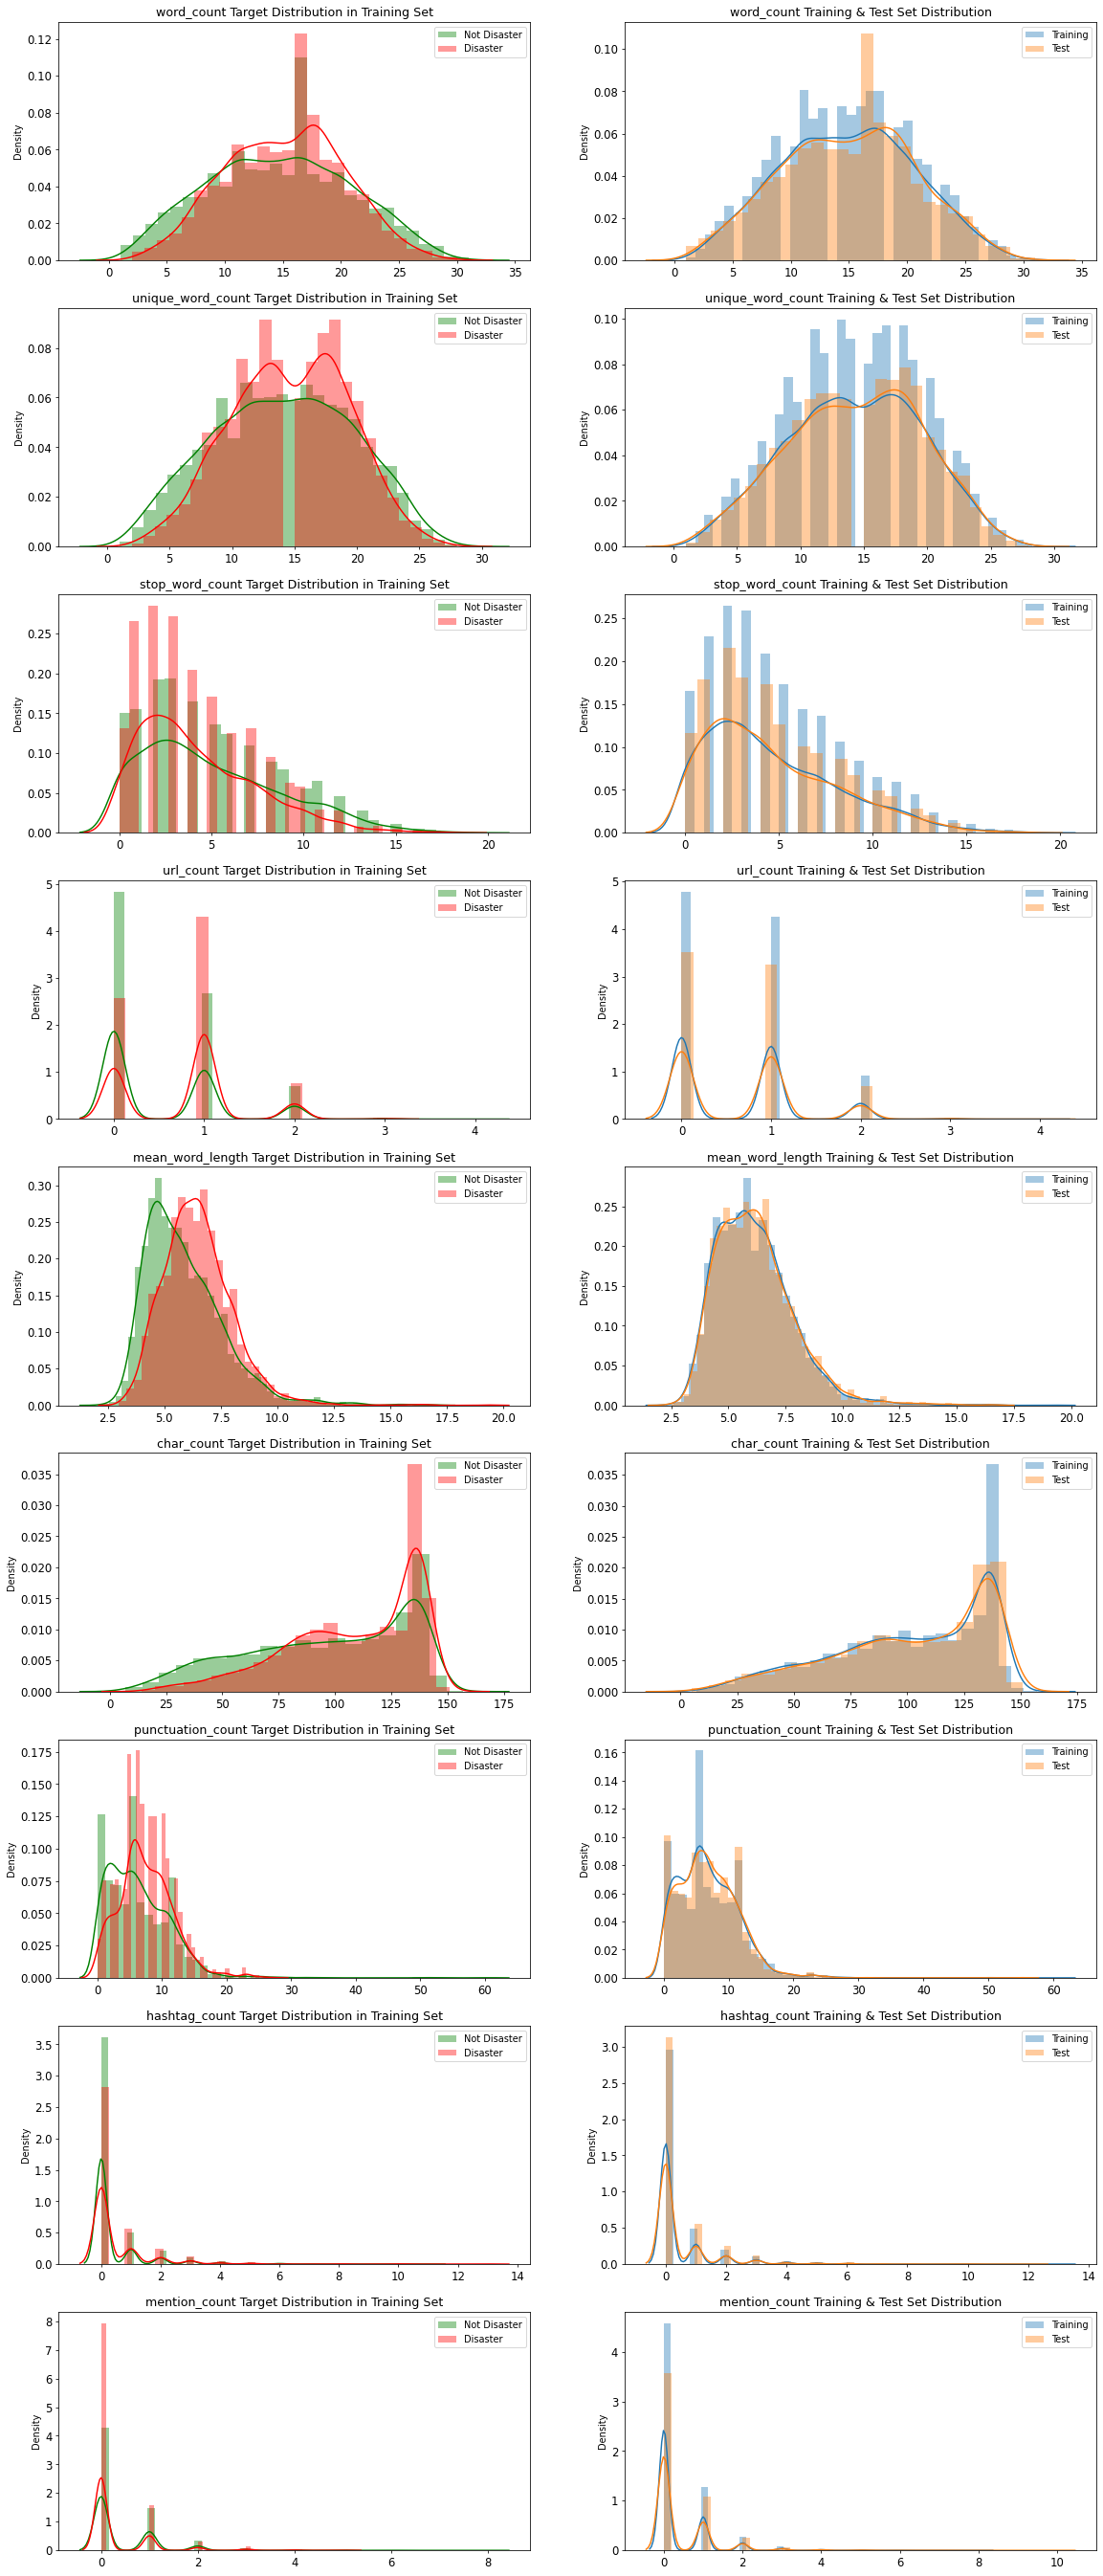

In [114]:
# word_count
train_df["word_count"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["word_count"] = test_df["text"].apply(lambda x: len(str(x).split()))

# unique_word_count
train_df["unique_word_count"] = train_df["text"].apply(
    lambda x: len(set(str(x).split()))
)
test_df["unique_word_count"] = test_df["text"].apply(lambda x: len(set(str(x).split())))

# stop_word_count
train_df["stop_word_count"] = train_df["text"].apply(
    lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS])
)
test_df["stop_word_count"] = test_df["text"].apply(
    lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS])
)

# url_count
train_df["url_count"] = train_df["text"].apply(
    lambda x: len([w for w in str(x).lower().split() if "http" in w or "https" in w])
)
test_df["url_count"] = test_df["text"].apply(
    lambda x: len([w for w in str(x).lower().split() if "http" in w or "https" in w])
)

# mean_word_length
train_df["mean_word_length"] = train_df["text"].apply(
    lambda x: np.mean([len(w) for w in str(x).split()])
)
test_df["mean_word_length"] = test_df["text"].apply(
    lambda x: np.mean([len(w) for w in str(x).split()])
)

# char_count
train_df["char_count"] = train_df["text"].apply(lambda x: len(str(x)))
test_df["char_count"] = test_df["text"].apply(lambda x: len(str(x)))

# punctuation_count
train_df["punctuation_count"] = train_df["text"].apply(
    lambda x: len([c for c in str(x) if c in string.punctuation])
)
test_df["punctuation_count"] = test_df["text"].apply(
    lambda x: len([c for c in str(x) if c in string.punctuation])
)

# hashtag_count
train_df["hashtag_count"] = train_df["text"].apply(
    lambda x: len([c for c in str(x) if c == "#"])
)
test_df["hashtag_count"] = test_df["text"].apply(
    lambda x: len([c for c in str(x) if c == "#"])
)

# mention_count
train_df["mention_count"] = train_df["text"].apply(
    lambda x: len([c for c in str(x) if c == "@"])
)
test_df["mention_count"] = test_df["text"].apply(
    lambda x: len([c for c in str(x) if c == "@"])
)

METAFEATURES = [
    "word_count",
    "unique_word_count",
    "stop_word_count",
    "url_count",
    "mean_word_length",
    "char_count",
    "punctuation_count",
    "hashtag_count",
    "mention_count",
]
DISASTER_TWEETS = train_df["target"] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=70)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(
        train_df.loc[~DISASTER_TWEETS][feature],
        label="Not Disaster",
        ax=axes[i][0],
        color="green",
    )
    sns.distplot(
        train_df.loc[DISASTER_TWEETS][feature],
        label="Disaster",
        ax=axes[i][0],
        color="red",
    )

    sns.distplot(train_df[feature], label="Training", ax=axes[i][1])
    sns.distplot(test_df[feature], label="Test", ax=axes[i][1])

    for j in range(2):
        axes[i][j].set_xlabel("")
        axes[i][j].tick_params(axis="x", labelsize=12)
        axes[i][j].tick_params(axis="y", labelsize=12)
        axes[i][j].legend()

    axes[i][0].set_title(f"{feature} Target Distribution in Training Set", fontsize=13)
    axes[i][1].set_title(f"{feature} Training & Test Set Distribution", fontsize=13)

plt.show()

## Insights

- All of the meta features have information about target as well, but some of them are not good enough such as url_count, hashtag_count and mention_count.
- On the other hand, word_count, unique_word_count, stop_word_count, mean_word_length, char_count, punctuation_count have very different distributions for disaster and non-disaster tweets. Those features might be useful for modelling purposes. 

In [209]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 7613 non-null   int64  
 1   keyword            7613 non-null   object 
 2   location           7613 non-null   object 
 3   text               7613 non-null   object 
 4   target             7613 non-null   int64  
 5   word_count         7613 non-null   int64  
 6   unique_word_count  7613 non-null   int64  
 7   stop_word_count    7613 non-null   int64  
 8   url_count          7613 non-null   int64  
 9   mean_word_length   7613 non-null   float64
 10  char_count         7613 non-null   int64  
 11  punctuation_count  7613 non-null   int64  
 12  hashtag_count      7613 non-null   int64  
 13  mention_count      7613 non-null   int64  
 14  processed_text     7613 non-null   object 
dtypes: float64(1), int64(10), object(4)
memory usage: 892.3+ KB


In [210]:
train_df.head()

,id,keyword,location,text,target,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,processed_text
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,13,13,6,0,4.384615,69,1,1,0,our deeds are the reason of this earthquake ma...
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,7,7,0,0,4.571429,38,1,0,0,forest fire near la ronge sask canada
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,22,20,11,0,5.090909,133,3,0,0,all residents asked to shelter in place are be...
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,8,8,1,0,7.125000,65,2,1,0,13 000 people receive wildfires evacuation ord...
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,16,15,7,0,4.500000,88,2,2,0,just got sent this photo from ruby alaska as s...


In [211]:
train_df.describe()

,id,target,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
count,7613.000000,7613.00000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000
mean,5441.934848,0.42966,14.903586,14.340733,4.672928,0.620255,6.128494,101.037436,6.839485,0.446999,0.362406
std,3137.116090,0.49506,5.732604,5.277160,3.559228,0.664104,1.675464,33.781325,4.608758,1.099841,0.720097
min,1.000000,0.00000,1.000000,1.000000,0.000000,0.000000,2.250000,7.000000,0.000000,0.000000,0.000000
25%,2734.000000,0.00000,11.000000,11.000000,2.000000,0.000000,4.875000,78.000000,3.000000,0.000000,0.000000
50%,5408.000000,0.00000,15.000000,14.000000,4.000000,1.000000,5.928571,107.000000,6.000000,0.000000,0.000000
75%,8146.000000,1.00000,19.000000,18.000000,7.000000,1.000000,7.058824,133.000000,10.000000,0.000000,1.000000
max,10873.000000,1.00000,31.000000,29.000000,19.000000,4.000000,19.333333,157.000000,61.000000,13.000000,8.000000


### Feature Engineering

In [223]:
# Used NLPretext library for standard text preprocessing
def pre_process_text(review_df: pd.DataFrame) -> pd.DataFrame:

    # preparing preprocessing pipeline
    preprocessor = Preprocessor()
    preprocessor.pipe(lower_text)
    preprocessor.pipe(remove_emoji)
    preprocessor.pipe(remove_mentions)
    preprocessor.pipe(unpack_english_contractions)
    preprocessor.pipe(remove_eol_characters)
    preprocessor.pipe(remove_punct)
    preprocessor.pipe(normalize_whitespace)

    #     preprocessor.pipe(remove_hashtag)
    #     preprocessor.pipe(remove_stopwords, args={"lang": "en"}) # dropping stopped words decreased model accuracy

    review_df[PROCESSED_COL] = review_df["text"].apply(lambda x: preprocessor.run(x))

    return review_df

In [224]:
def copy(df: pd.DataFrame) -> pd.DataFrame:
    return df.copy()


def drop(df: pd.DataFrame, col: str) -> pd.DataFrame:
    return df.drop(col, axis=1)


def scale_col(df: pd.DataFrame, col: str) -> pd.DataFrame:
    std_scaler = StandardScaler()
    df[col] = std_scaler.fit_transform(df[col].values.reshape(-1, 1))
    return df

In [225]:
def transform_data(df: pd.DataFrame) -> pd.DataFrame:
    return (
        df.pipe(copy)
        .pipe(drop, "id")
        .pipe(drop, "keyword")
        .pipe(drop, "location")
        .pipe(drop, "text")
        .pipe(
            drop, "url_count"
        )  # dropping all meta features for now. Can try them later to see if they improve the results or not.
        .pipe(drop, "hashtag_count")  # dropping all meta features for now
        .pipe(drop, "mention_count")  # dropping all meta features for now
        .pipe(drop, "word_count")  # dropping all meta features for now
        .pipe(drop, "unique_word_count")  # dropping all meta features for now
        .pipe(drop, "stop_word_count")  # dropping all meta features for now
        .pipe(drop, "mean_word_length")  # dropping all meta features for now
        .pipe(drop, "char_count")  # dropping all meta features for now
        .pipe(drop, "punctuation_count")  # dropping all meta features for now
    )

In [226]:
PROCESSED_COL = "processed_text"
TWEETS_TRAIN_CSV_PATH = "../nlp-getting-started/train.csv"
# text pre_processing pipeline
processed_tweets_df = pipe(
    train_df,
    pre_process_text,
    transform_data,
)

In [227]:
processed_tweets_df

,target,processed_text
0,1,our deeds are the reason of this earthquake ma...
1,1,forest fire near la ronge sask canada
2,1,all residents asked to shelter in place are be...
3,1,13 000 people receive wildfires evacuation ord...
4,1,just got sent this photo from ruby alaska as s...
...,...,...
7608,1,two giant cranes holding a bridge collapse int...
7609,1,the out of control wild fires in california ev...
7610,1,m1 94 01 04 utc 5km s of volcano hawaii http t...
7611,1,police investigating after an e bike collided ...


### Mine Train/Test Dataset

In [228]:
def extract_features_and_target(
    df: pd.DataFrame, target_col: str
) -> Tuple[np.ndarray, np.ndarray]:
    df_target = df[target_col]
    assert df_target.to_numpy().ndim == 1

    df_features = df.drop(columns=[target_col])

    X = df_features
    y = df_target.to_numpy()

    return X, y

In [229]:
# using tranformed DF which has a column for disaster/non-disaster tweets (to be used here as labels)
corpus, y = extract_features_and_target(processed_tweets_df, "target")
corpus_train, corpus_test, y_train, y_test = train_test_split(
    corpus, y, test_size=0.2, random_state=7
)

## 1. First Approach (TF-IDF vectorization for numericalization of features)

In [230]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(corpus_train["processed_text"].to_list())
X_test = vectorizer.transform(corpus_test["processed_text"].to_list())

### Train various models on TF-IDF vectorized text features

In [231]:
models = [
    sklearn.dummy.DummyClassifier(
        strategy="stratified"
    ),  # baseline (learned model must do better than this)
    sklearn.linear_model.LogisticRegression(),
    sklearn.ensemble.RandomForestClassifier(),
    xgboost.XGBClassifier(),
    sklearn.svm.SVC(),
]


for model in models:
    print(model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("confusion matrix : ", confusion_matrix(y_test, y_pred))
    print("accuracy : ", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("***************************************************")

DummyClassifier(strategy='stratified')
confusion matrix :  [[504 357]
 [371 291]]
accuracy :  0.5219960604070912
              precision    recall  f1-score   support

           0       0.58      0.59      0.58       861
           1       0.45      0.44      0.44       662

    accuracy                           0.52      1523
   macro avg       0.51      0.51      0.51      1523
weighted avg       0.52      0.52      0.52      1523

***************************************************
LogisticRegression()
confusion matrix :  [[749 112]
 [184 478]]
accuracy :  0.8056467498358503
              precision    recall  f1-score   support

           0       0.80      0.87      0.84       861
           1       0.81      0.72      0.76       662

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.80      1523

***************************************************
RandomForestClassifier()
confusion

## Insights

- LogisticRegression and SVC seems to be giving the best results on test set. 

## Crossvalidate model (LogisticRegression)

In [232]:
def cross_validatation_score(
    model: sklearn.linear_model,
    X_train: np.ndarray,
    y_train: np.ndarray,
    scoring_metric: str,
) -> None:
    score = cross_val_score(
        model,
        X_train,
        y_train,
        scoring=scoring_metric,
        cv=10,
    )
    print(f"{scoring_metric} = {score.mean():5.4f} +/- {score.std():5.4f}")


scoring_metrics = ["accuracy", "precision", "recall", "f1"]

for metric in scoring_metrics:
    cross_validatation_score(
        sklearn.linear_model.LogisticRegression(), X_train, y_train, metric
    )

accuracy = 0.7985 +/- 0.0115
precision = 0.8350 +/- 0.0143
recall = 0.6604 +/- 0.0271
f1 = 0.7372 +/- 0.0186


## 2. Second Approach (Finetune pre-trained DistilBERT on the disaster classification task)

### Finetuning DistilBERT on train dataset

In [12]:
# Define pretrained tokenizer and model
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
# DistilBert Model transformer with a sequence classification/regression head on top (a linear layer on top of the pooled output)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2) 

# Preprocess data
X_train, X_test, y_train, y_test = train_test_split(corpus, y, test_size=0.2)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])


train_dataset = Dataset(X_train_tokenized, y_train)
test_dataset = Dataset(X_test_tokenized, y_test)

# Define Trainer parameters
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


# Define Trainer
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

# Train pre-trained model
trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Runtime,Samples Per Second
500,0.335300,0.483446,0.826001,0.787781,0.786517,0.787149,72.438000,21.025000


TrainOutput(global_step=573, training_loss=0.31941288220736785, metrics={'train_runtime': 3418.2741, 'train_samples_per_second': 0.168, 'total_flos': 403678450791000.0, 'epoch': 3.0})

### Predicting target label on test dataset using fine-tuned DistilBERT 

In [18]:
TWEETS_TEST_CSV_PATH = "../nlp-getting-started/test.csv"
processed_test_tweets_df = pipe(
    TWEETS_TEST_CSV_PATH,
    pd.read_csv,
    pre_process,
)

# Load test data
X_test = list(processed_test_tweets_df[PROCESSED_COL])
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
test_dataset = Dataset(X_test_tokenized)

# Load trained model
model_path = "output/checkpoint-500"
model = DistilBertForSequenceClassification.from_pretrained(model_path, num_labels=2)

# Define test trainer
test_trainer = Trainer(model)

# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

### Exporting results into `predicted_test.csv`

In [22]:
processed_test_tweets_df["target"] = y_pred
processed_test_tweets_df[["id", "location", "text", "target"]].to_csv(
    "../nlp-getting-started/predicted_test.csv"
)

## 3. Third Appraoch (Zero-shot text classification pipeline from HuggingFace) Zero-shot learning

1. Zero shot learning works by learning a classifier on one set of labels and then evaluate on a different set of labels that the classifier has never seen before. The pipeline can use any model trained on an NLI task. It works by posing each candidate label as a “hypothesis” and the sequence which we want to classify as the “premise”.
2. `Motivation` : As we don't have many labels to train our classifier on & DL models are data hungry, I thought to give it a try. Also, in real world sentence classification problems, we might not have training labels available.

In [233]:
class Pred(NamedTuple):
    """Collect the predictions in this class to avoid misspelling."""

    tweet: str
    tweet_id: int
    target_pred: str

In [14]:
def init_pipeline() -> pipeline:
    print("# Init model... (this might take a while)")
    return pipeline(
        "zero-shot-classification",
    )

In [23]:
def classify_tweets(
    zero_shot_pipeline: pipeline,
    tweets: List[str],
    tweet_ids: List[int],
    candidate_labels: List[str],
):
    candidate_labels = ["disaster", "not a disaster"] 
    hypothesis_template = "The tweet is about {}."

    for (
        tweet,
        tweet_id,
    ) in zip(tweets, tweet_ids):

        result = zero_shot_pipeline(
            tweet,
            candidate_labels,
            hypothesis_template=hypothesis_template,
        )

        pred = Pred(
            tweet=tweet,
            tweet_id=tweet_id,
            target_pred=result["labels"][0],
        )

        yield pred

In [26]:
def classify(
    tweets: List[str],
    tweet_ids: List[int],
    candidate_labels: List[str],
    verbose=0,
) -> List[Dict]:
    assert isinstance(tweets, list)

    zero_shot_pipeline = init_pipeline()

    print(f"Len: {len(tweets)}")
    results = []
    n = len(tweets)
    for i, result in enumerate(
        tqdm(
            classify_tweets(
                zero_shot_pipeline,
                tweets,
                tweet_ids,
                candidate_labels,
            )
        )
    ):
        results.append(result)

    return results

In [27]:
results = classify(
    corpus,
    processed_tweets_df["id"].values.tolist(),
    [],
)

# Init model... (this might take a while)


0it [00:00, ?it/s]

Len: 7613


7613it [1:30:18,  1.40it/s]


In [47]:
y_pred = [result.target_pred == "disaster" for result in results]
print(
    "accuracy score : ",
    accuracy_score(y_pred, processed_tweets_df["target"].values.tolist()),
)
### Yielded accuracy score of 0.56. I might need need to improve cadidate labels to provide better classification signle.

## Future Improvements

- Use meta features along with TF-IDF features to train non deep learning models. Hyperparameter Optimization.
- Train DistilBERT for more epochs and implement proper corss-validation. Plot train/validation plots to get a better understanding of loss curve. Optimize hyperparameters.
- For zero-shot learning classifier, try different candidate labels to provide more implicit class signal.